In [1]:
import sys,os,string
import numpy as np, scipy
from numpy import log as ln, log10 as log
from astropy import units as un, constants as cons
import pylab as pl

In [2]:
sys.path.append('../../../CGM_ICs/pysrc/')
import HaloPotential_old as halo
import HaloPotential as halo

In [3]:
BehrooziDataDir = '/Users/jonathanstern/Dropbox/programs/umachine-dr1/data/'
BehrooziFile = BehrooziDataDir + 'smhm/params/smhm_true_med_cen_params.txt'

def Behroozi_params(z, parameter_file=BehrooziFile):
    param_file = open(parameter_file, "r")
    param_list = []
    allparams = []
    for line in param_file:
        param_list.append(float((line.split(" "))[1]))
        allparams.append(line.split(" "))
    
    if (len(param_list) != 20):
        print(("Parameter file not correct length.  (Expected 20 lines, got %d)." % len(param_list)))
        quit()
    
    names = "EFF_0 EFF_0_A EFF_0_A2 EFF_0_Z M_1 M_1_A M_1_A2 M_1_Z ALPHA ALPHA_A ALPHA_A2 ALPHA_Z BETA BETA_A BETA_Z DELTA GAMMA GAMMA_A GAMMA_Z CHI2".split(" ");
    params = dict(list(zip(names, param_list)))
    
    
    #Print SMHM relation
    a = 1.0/(1.0+z)
    a1 = a - 1.0
    lna = ln(a)
    zparams = {}
    zparams['m_1'] = params['M_1'] + a1*params['M_1_A'] - lna*params['M_1_A2'] + z*params['M_1_Z']
    zparams['sm_0'] = zparams['m_1'] + params['EFF_0'] + a1*params['EFF_0_A'] - lna*params['EFF_0_A2'] + z*params['EFF_0_Z']
    zparams['alpha'] = params['ALPHA'] + a1*params['ALPHA_A'] - lna*params['ALPHA_A2'] + z*params['ALPHA_Z']
    zparams['beta'] = params['BETA'] + a1*params['BETA_A'] + z*params['BETA_Z']
    zparams['delta'] = params['DELTA']
    zparams['gamma'] = 10**(params['GAMMA'] + a1*params['GAMMA_A'] + z*params['GAMMA_Z'])
    
    smhm_max = 14.5-0.35*z
    if (params['CHI2']>200):
        print('#Warning: chi^2 > 200 implies that not all features are well fit.  Comparison with the raw data (in data/smhm/median_raw/) is crucial.')
    ms = 0.05 * np.arange(int(10.5*20),int(smhm_max*20+1),1)
    dms = ms - zparams['m_1'] 
    dm2s = dms/zparams['delta']
    sms = zparams['sm_0'] - log(10**(-zparams['alpha']*dms) + 10**(-zparams['beta']*dms)) + zparams['gamma']*np.e**(-0.5*(dm2s*dm2s))
    return ms,sms

def MgalaxyBehroozi(lMhalo, z, parameter_file=BehrooziFile):
    ms,sms = Behroozi_params(z,parameter_file)
    lMstar = scipy.interpolate.interp1d(ms, sms, fill_value='extrapolate')(lMhalo)
    return 10.**lMstar*un.Msun
def MgalaxyBehroozi_extrapolate(lMhalo, z, polydeg=2,parameter_file=BehrooziFile):
    log_z_plus_1s = np.arange(0.7,1,.025)
    _lMgalaxies = [log(MgalaxyBehroozi(lMhalo,10**log_z_plus_1-1.,parameter_file=parameter_file).value) for log_z_plus_1 in log_z_plus_1s]
    poly = np.poly1d(np.polyfit(log_z_plus_1s, _lMgalaxies, polydeg))
    return 10.**poly(log(z+1))*un.Msun

def MhaloBehroozi(lMstar, z, parameter_file=BehrooziFile):
    ms,sms = Behroozi_params(z,parameter_file)
    lMhalo = scipy.interpolate.interp1d(sms, ms, fill_value='extrapolate')(lMstar)
    return 10.**lMhalo*un.Msun
def c_DuttonMaccio14(lMhalo, z=0):  #table 3 appropriate for Mvir
    c_z0  = lambda lMhalo: 10.**(1.025 - 0.097*(lMhalo-log(0.7**-1*1e12))) 
    c_z05 = lambda lMhalo: 10.**(0.884 - 0.085*(lMhalo-log(0.7**-1*1e12))) 
    c_z1  = lambda lMhalo: 10.**(0.775 - 0.073*(lMhalo-log(0.7**-1*1e12))) 
    c_z2  = lambda lMhalo: 10.**(0.643 - 0.051*(lMhalo-log(0.7**-1*1e12)))
    zs = np.array([0.,0.5,1.,2.])
    cs = np.array([c_func(lMhalo) for c_func in (c_z0,c_z05,c_z1,c_z2)])
    return np.interp(z, zs, cs)
    

(0.0001, 0.1)

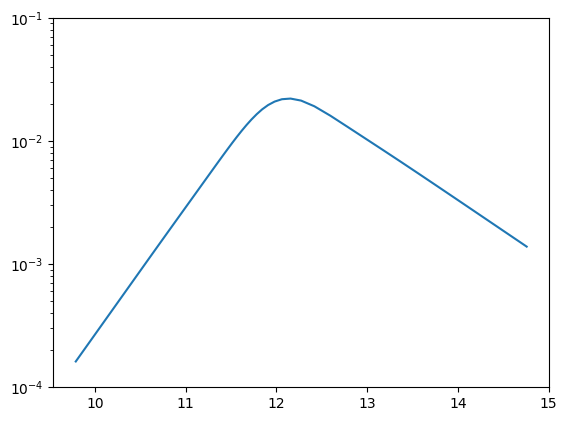

In [4]:
lMstars = np.arange(6,12,.1); z = 0.1
lMhalos = log(MhaloBehroozi(lMstars,z).value)
pl.plot(lMhalos, 10.**(lMstars - lMhalos))
pl.semilogy()
pl.ylim(1e-4,0.1)

In [5]:
class Sightline:
    def __init__(self,z,Rperp,logMstar,SFR):
        self.z=z
        self.Rperp=Rperp*un.kpc
        self.Mstar=10**logMstar*un.Msun
        self.SFR = SFR*un.Msun/un.yr
        self.Ws = {}
        self.NHs = {}
    def isSF(self):
        return self.SFR/self.Mstar > 1e-11*un.yr**-1
    def Mhalo(self):
        return MhaloBehroozi(log(self.Mstar.value),self.z)
    def Rvir(self):
        cvir = c_DuttonMaccio14(log(self.Mhalo().value),self.z)
        return halo.NFW(self.Mhalo(),self.z, cvir).rvir()
        # return 290 * (self.Mhalo()/(1e12*un.Msun))**(1/3)*(1+self.z)**-0.9 * un.kpc
    def W_MgII(self):
        return (self.Ws['Mg II  2796'][0]+self.Ws['Mg II  2803'][0])/1000*un.angstrom

In [6]:
0.2*Sightline(0.05,10,9.5,1).Rvir()

<Quantity 35.29569686 kpc>

In [6]:
COSHalos = {}
for l in open('../../data/COSHalos_data/Werk13_Table1.txt').readlines(): 
    if l[0]=='#': continue
    ll = l.split()
    name = ll[0]
    z,Rperp,logMstar = map(float, ll[1:4])
    if ll[-2][0]=='<': SFR = 0.
    else: SFR = float(ll[-2])
    COSHalos[name] = Sightline(z,Rperp,logMstar,SFR)

In [7]:
for l in open('../../data/COSHalos_data/Werk13_Table3.txt').readlines():
    if l[0]=='#': continue
    name = l[:17]
    while name[-1]==' ': name=name[:-1]
    ion = l[29:40]
    W_isUL = l[51]=='<'
    W = float(l[53:57])*un.angstrom
    if l[58:61]=='   ': eW=0*un.angstrom
    else: eW= float(l[58:61])*un.angstrom
    COSHalos[name].Ws[ion] = (W,eW,W_isUL)
    NH_isUL = l[78]=='<'
    NH_isLL = l[78]=='>'
    if l[80:85]=='     ': continue
    lNH = float(l[80:85])
        

In [8]:
for l in open('../../data/COSHalos_data/Prochaska17_table1.txt').readlines():
    if l[0]=='#': continue
    name = l.split()[0]
    if l.split()[-1]=='cdots': 
        logNHI = float(l.split()[-2][1:])
        NHI_isUL = l.split()[-2][0]=='<'
        NHI_isLL = l.split()[-2][0]=='>'
        logNHI_max = logNHI_min  = None
    else:
        NHI_isUL = NHI_isLL = False
        logNHI = float(l.split()[-3])
        logNHI_max = float(l.split()[-1])
        logNHI_min = float(l.split()[-2][:-1])
    COSHalos[name].NHs['HI'] = (logNHI, logNHI_min, logNHI_max, NHI_isLL, NHI_isUL,'Prochaska17')
print(len(COSHalos),len([o for name,o in COSHalos.items() if 'HI' in o.NHs]))

44 21


In [10]:
for l in open('../../data/COSHalos_data/Werk14_Table1.txt').readlines():
    if l[0]=='#': continue
    name = '_'.join(l.split()[:2])
    COSHalos[name].r2rvir_Werk14 = float(l.split()[4])
    if 'HI' in COSHalos[name].NHs: continue
    NHIstr = l.split()[7:10]
    if  NHIstr[0][0]=='[':
        a,b = float(NHIstr[1][:-1]), float(NHIstr[2][:-1])
        COSHalos[name].NHs['HI'] = ((a+b)/2,a,b, False, False,'Werk14')
    elif NHIstr[0][0]=='<':
        a = float(NHIstr[0][1:])
        COSHalos[name].NHs['HI'] = (a,None,None, False, True,'Werk14')
    else:
        a,b = float(NHIstr[0]), float(NHIstr[2])
        COSHalos[name].NHs['HI'] = (a,a-b,a+b, False, False,'Werk14')
#print(len(COSHalos),len([o.NHs['HI'][

26
[5, 0.23099999999999996, 0.15597948583066942]


Text(0, 0.5, '$N_{\\rm HI}$')

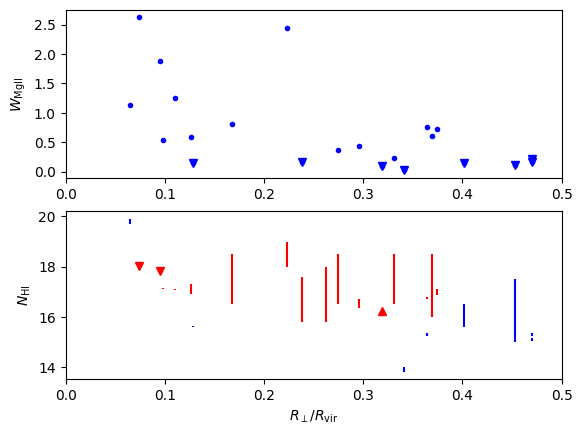

In [23]:
ax1 = pl.subplot(211)
isSF = True
ions = ('Mg II  2796','Mg II  2803')
#16% difference in Rvir if using Moster relation at Mstar=3e10
vals = [o for name,o in COSHalos.items() if (False not in [ion in o.Ws for ion in ions]) and o.isSF()==isSF]
print(len(vals))
xs = [o.Rperp.value/o.Rvir().value for o in vals] 
ys = [o.W_MgII().value for o in vals]
print([f([o.W_MgII().value  for o in vals if 0.25<o.Rperp.value/o.Rvir().value<0.35]) for f in (len,np.mean,np.std)])
pl.plot(xs,ys,'.',c='rb'[isSF])
valsUL = [o for o in vals if (True in [o.Ws[ion][2] for ion in ions])]
xs = [o.Rperp.value/o.Rvir().value for o in valsUL] 
ys = [o.W_MgII().value for o in valsUL]
pl.plot(xs,ys,'v',c='rb'[isSF])
pl.xlim(0,0.5)
pl.ylabel(r'$W_{\rm MgII}$')
ax2 = pl.subplot(212)
for isWerk14 in True,False:
    vals = [o for name,o in COSHalos.items() if 'HI' in o.NHs and o.isSF()==isSF and (o.NHs['HI'][5]=='Werk14')==isWerk14]
    valsRng = [o for o in vals if not o.NHs['HI'][3] and not o.NHs['HI'][4]]
    xs = [o.Rperp.value/o.Rvir().value for o in valsRng] 
    ys = [o.NHs['HI'][0] for o in valsRng]
    yerrs = np.array([[o.NHs['HI'][0]-o.NHs['HI'][1],o.NHs['HI'][2]-o.NHs['HI'][0]] for o in valsRng]).T
    pl.errorbar(xs,ys,yerrs,c='rb'[isWerk14],ls='')
    valsUL = [o for o in vals if o.NHs['HI'][3]]
    xs = [o.Rperp.value/o.Rvir().value for o in valsUL] 
    ys = [o.NHs['HI'][0] for o in valsUL]
    pl.plot(xs,ys,'v',c='rb'[isWerk14])
    valsLL = [o for o in vals if o.NHs['HI'][4]]
    xs = [o.Rperp.value/o.Rvir().value for o in valsLL] 
    ys = [o.NHs['HI'][0] for o in valsLL]
    pl.plot(xs,ys,'^',c='rb'[isWerk14])
pl.xlim(0,0.5)
pl.xlabel(r'$R_\perp/R_{\rm vir}$')
pl.ylabel(r'$N_{\rm HI}$')

11
17


Text(0, 0.5, '$N_{\\rm HI}$')

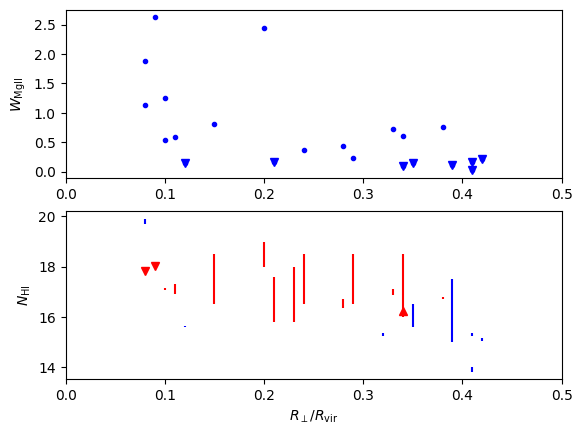

In [12]:
ax1 = pl.subplot(211)
isSF = True
ions = ('Mg II  2796','Mg II  2803')
#16% difference in Rvir if using Moster relation at Mstar=3e10
vals = [o for name,o in COSHalos.items() if (False not in [ion in o.Ws for ion in ions]) and o.isSF()==isSF]
xs = [o.r2rvir_Werk14 for o in vals] 
ys = [o.W_MgII().value for o in vals]
pl.plot(xs,ys,'.',c='rb'[isSF])
valsUL = [o for o in vals if (True in [o.Ws[ion][2] for ion in ions])]
xs = [o.r2rvir_Werk14 for o in valsUL] 
ys = [o.W_MgII().value for o in valsUL]
pl.plot(xs,ys,'v',c='rb'[isSF])
pl.xlim(0,0.5)
pl.ylabel(r'$W_{\rm MgII}$')
ax2 = pl.subplot(212)
for isWerk14 in True,False:
    vals = [o for name,o in COSHalos.items() if 'HI' in o.NHs and o.isSF()==isSF and (o.NHs['HI'][5]=='Werk14')==isWerk14]
    print(len(vals))
    valsRng = [o for o in vals if not o.NHs['HI'][3] and not o.NHs['HI'][4]]
    xs = [o.r2rvir_Werk14 for o in valsRng] 
    ys = [o.NHs['HI'][0] for o in valsRng]
    yerrs = np.array([[o.NHs['HI'][0]-o.NHs['HI'][1],o.NHs['HI'][2]-o.NHs['HI'][0]] for o in valsRng]).T
    pl.errorbar(xs,ys,yerrs,c='rb'[isWerk14],ls='')
    valsUL = [o for o in vals if o.NHs['HI'][3]]
    xs = [o.r2rvir_Werk14 for o in valsUL] 
    ys = [o.NHs['HI'][0] for o in valsUL]
    pl.plot(xs,ys,'v',c='rb'[isWerk14])
    valsLL = [o for o in vals if o.NHs['HI'][4]]
    xs = [o.r2rvir_Werk14 for o in valsLL] 
    ys = [o.NHs['HI'][0] for o in valsLL]
    pl.plot(xs,ys,'^',c='rb'[isWerk14])
pl.xlim(0,0.5)
pl.xlabel(r'$R_\perp/R_{\rm vir}$')
pl.ylabel(r'$N_{\rm HI}$')

In [ ]:
pl.plot(

In [22]:
[o.NHs['HI'] for k,o in COSHalos.items() if 'HI' in o.NHs]

[(17.25, 16.0, 18.5, False, False),
 (16.58, 16.51, 16.62, False, False),
 (16.24, None, None, False, True),
 (16.65, None, None, False, True),
 (17.91, None, None, True, False),
 (17.5, 16.5, 18.5, False, False),
 (18.5, 18.0, 19.0, False, False),
 (17.1, 17.08, 17.11, False, False),
 (17.5, 16.5, 18.5, False, False),
 (16.7, 15.8, 17.6, False, False),
 (17.7, None, None, True, False),
 (16.9, 15.8, 18.0, False, False),
 (17.01, None, None, False, True),
 (16.74, 16.69, 16.77, False, False),
 (17.83, None, None, True, False),
 (17.14, 17.1, 17.16, False, False),
 (17.03, 16.88, 17.11, False, False),
 (18.04, None, None, True, False),
 (16.63, 16.33, 16.72, False, False),
 (17.5, 16.5, 18.5, False, False),
 (17.17, 16.91, 17.3, False, False)]

[]

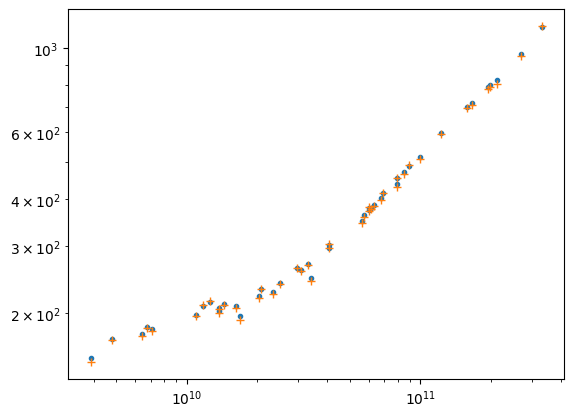

In [13]:
pl.plot([o.Mstar.value for name,o in COSHalos.items()],[o.Rvir().value for name,o in COSHalos.items()],'.')
pl.plot([o.Mstar.value for name,o in COSHalos.items()],
        [275 * (self.Mhalo()/(1e12*un.Msun))**(1/3)*(1+self.z)**-0.9 for name,self in COSHalos.items()],'+')
pl.loglog()

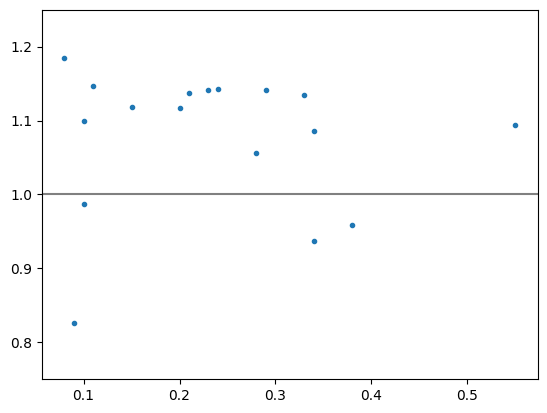

In [17]:
vals = [o for name,o in COSHalos.items() if 'HI' in o.NHs and o.isSF()==isSF and (o.NHs['HI'][5]=='Werk14')==isWerk14]
pl.plot([o.r2rvir_Werk14 for o in vals],[o.Rperp/o.Rvir()/o.r2rvir_Werk14 for o in vals],'.')
pl.ylim(0.75,1.25)
pl.axhline(1,c='.5')

(0.0, 1.0)

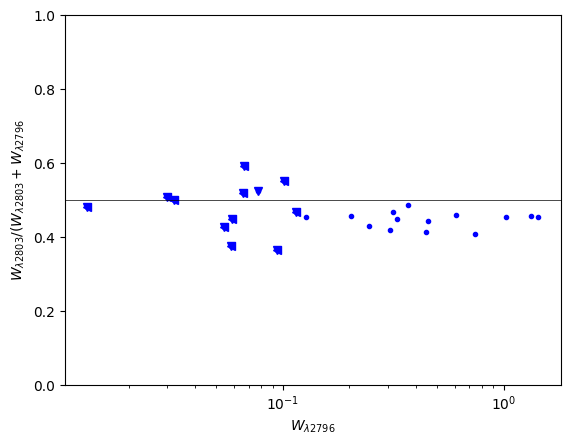

In [15]:
ions = ('Mg II  2796','Mg II  2803')
for isSF in True,:
    vals = [o for name,o in COSHalos.items() if (False not in [ion in o.Ws for ion in ions]) and o.isSF()==isSF]
    xs = [o.Ws[ions[0]][0].value/1000 for o in vals] 
    ys = [o.Ws[ions[1]][0].value/1000/o.W_MgII().value for o in vals] 
    pl.plot(xs,ys,'.',c='rb'[isSF])
    for ULs in range(2):
        valsUL = [o for o in vals if o.Ws[ions[ULs]][2]]
        xs = [o.Ws[ions[0]][0].value/1000 for o in valsUL] 
        ys = [o.Ws[ions[1]][0].value/1000/o.W_MgII().value for o in valsUL] 
        pl.plot(xs,ys,'<v'[ULs],c='rb'[isSF])
pl.semilogx()
pl.axhline(0.5,c='k',lw=0.5)
pl.ylabel(r'$W_{\lambda2803}/(W_{\lambda2803}+W_{\lambda 2796}$')
pl.xlabel(r'$W_{\lambda2796}$')
pl.ylim(0,1.)

In [16]:
sorted(['%s %.2f %.1f %d %.3f'%(k,v.z,log(v.Mstar.value),v.Rperp.value,v.Rperp/v.Rvir()) for k,v in COSHalos.items()])[:40]

['J0226+0015_268_22 0.23 10.8 78 0.202',
 'J0401-0540_67_24 0.22 10.1 83 0.401',
 'J0803+4332_306_20 0.25 11.3 77 0.096',
 'J0910+1014_242_34 0.26 11.4 135 0.140',
 'J0910+1014_34_46 0.14 10.6 112 0.369',
 'J0914+2823_41_27 0.24 9.8 101 0.572',
 'J0925+4004_196_22 0.25 11.3 83 0.105',
 'J0928+6025_110_35 0.15 10.8 91 0.240',
 'J0935+0204_15_28 0.26 11.0 110 0.213',
 'J0943+0531_106_34 0.23 10.8 121 0.319',
 'J0943+0531_216_61 0.14 10.9 149 0.304',
 'J0943+0531_227_19 0.35 9.6 92 0.602',
 'J0950+4831_177_27 0.21 11.2 91 0.130',
 'J1009+0713_170_9 0.36 10.2 44 0.223',
 'J1009+0713_204_17 0.23 9.8 60 0.331',
 'J1016+4706_274_6 0.25 10.2 23 0.110',
 'J1016+4706_359_16 0.17 10.5 44 0.168',
 'J1112+3539_236_14 0.25 10.3 53 0.239',
 'J1133+0327_110_5 0.24 11.2 18 0.025',
 'J1133+0327_164_21 0.15 10.1 55 0.263',
 'J1157-0022_230_7 0.16 10.8 19 0.046',
 'J1220+3853_225_38 0.27 10.8 154 0.439',
 'J1233+4758_94_38 0.22 10.8 132 0.364',
 'J1233-0031_168_7 0.32 10.5 32 0.129',
 'J1241+5721_199_6 0.

In [17]:
Om=0.3
x=Om-1
18*np.pi**2+82*x-39*x**2

101.14287921960845